# Market segmentation: K-means ranking
In this notebook, we identify 5 clusters of merchants by their associated tags and produce a top 10 rank for each segment identified.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd

In [2]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Categories")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "10g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/18 23:06:22 WARN Utils: Your hostname, DESKTOP-702MS12 resolves to a loopback address: 127.0.1.1; using 172.17.210.38 instead (on interface eth0)
24/10/18 23:06:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 23:06:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/18 23:06:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/18 23:06:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer

In [4]:
merchant = spark.read.parquet("../data/curated/part_1/clean_merchant.parquet")
goods = merchant.select("goods")

In [5]:
merchant.count()

4026

In [6]:
# Step 1: Clean the 'goods' column by removing punctuation and converting to lowercase
clean_goods = goods.withColumn("str_goods", lower(regexp_replace("goods", "[^\w\s]", "")))

# Step 2: Tokenize the cleaned 'str_goods' column
tokenizer = Tokenizer(inputCol="str_goods", outputCol="tokens")
clean_goods = tokenizer.transform(clean_goods)

# Step 3: Get default stop words from StopWordsRemover
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")

# Step 4: Add custom stop words to the list
additional_stopwords = ['new', 'shops', 'supplies', 'parts', 'services', '', 
                        'supply', 'integrated', 'equipment', 'sales', 
                        'dealers', 'restoration']
all_stopwords = default_stopwords + additional_stopwords

# Step 5: Remove stop words, including the additional custom words
remover = StopWordsRemover(inputCol="tokens", outputCol="clean_goods", stopWords=all_stopwords)
clean_goods = remover.transform(clean_goods)

# Step 6: Select only the 'clean_goods' column
clean_goods = clean_goods.select('clean_goods')

# Show the results
clean_goods.show(truncate=False)


+-----------------------------------------------------------------+
|clean_goods                                                      |
+-----------------------------------------------------------------+
|[watch, clock, jewelry, repair]                                  |
|[motor, vehicle]                                                 |
|[cable, satellite, pay, television, radio]                       |
|[opticians, optical, goods, eyeglasses]                          |
|[watch, clock, jewelry, repair]                                  |
|[antique, repairs]                                               |
|[tent, awning]                                                   |
|[bicycle, service]                                               |
|[motor, vehicle]                                                 |
|[motor, vehicle]                                                 |
|[watch, clock, jewelry, repair]                                  |
|[tent, awning]                                 

In [7]:
clean_goods.show(5, truncate=False)

+------------------------------------------+
|clean_goods                               |
+------------------------------------------+
|[watch, clock, jewelry, repair]           |
|[motor, vehicle]                          |
|[cable, satellite, pay, television, radio]|
|[opticians, optical, goods, eyeglasses]   |
|[watch, clock, jewelry, repair]           |
+------------------------------------------+
only showing top 5 rows



In [8]:
# Add an index to both DataFrames to ensure they align
from pyspark.sql.functions import monotonically_increasing_id

# Add an index column to df1
df1_with_index = merchant.withColumn("index", monotonically_increasing_id())

# Add an index column to df2
df2_with_index = clean_goods.withColumn("index", monotonically_increasing_id())

# Join the DataFrames on the index column
df_combined = df1_with_index.join(df2_with_index, on="index", how="inner").drop("index")

# Show the combined DataFrame
df_combined.show(truncate=False)

+------------+--------------------------------------+-------------------------------------------------------------------------------------+-------------+---------+------------------+-------------------+------------------+------------------+-----------------------------------------------------------------+
|merchant_abn|name                                  |goods                                                                                |revenue_level|take_rate|sum(dollar_value) |count(dollar_value)|log_ratio         |unscaled_earning  |clean_goods                                                      |
+------------+--------------------------------------+-------------------------------------------------------------------------------------+-------------+---------+------------------+-------------------+------------------+------------------+-----------------------------------------------------------------+
|12516851436 |Mollis Corp.                          |watch, clock, and jewelry 

In [9]:
from pyspark.ml.feature import Word2Vec

# Step 1: Initialize the Word2Vec model
word2vec = Word2Vec(vectorSize=10, inputCol="clean_goods", outputCol="clean_goods_word2vec")

# Step 2: Train the Word2Vec model
model = word2vec.fit(df_combined)

# Step 3: Transform the 'clean_goods' column into word vectors
df_word2vec = model.transform(df_combined)

# Show the resulting DataFrame with word vectors
df_word2vec.select("clean_goods", "clean_goods_word2vec").show(truncate=False)

+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_goods                                                      |clean_goods_word2vec                                                                                                                                                                                      |
+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[watch, clock, jewelry, repair]                                  |[-0.12337842211127281,0.2956372667104006,0.7253710553050041,-1.3976886570453644,-0.36372148990631104,0.8334324955940247,

# K-Means Clustering

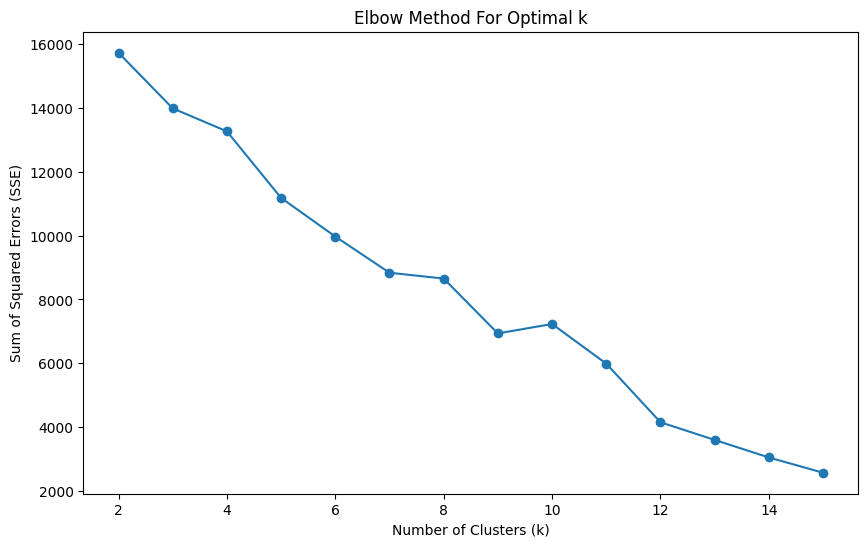

In [10]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

# Step 1: Create a list to store the SSE values for each k
sse = []

# Step 2: Test K-Means with different values of k (e.g., from 2 to 10 clusters)
for k in range(2, 16):
    kmeans = KMeans(featuresCol="clean_goods_word2vec", predictionCol="cluster", k=k)
    kmeans_model = kmeans.fit(df_word2vec)
    
    # Compute the Sum of Squared Errors (SSE) and append to the list
    sse.append(kmeans_model.summary.trainingCost)

# Step 3: Plot the SSE against k to find the "elbow" point
plt.figure(figsize=(10,6))
plt.plot(range(2, 16), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [11]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="clean_goods_word2vec", predictionCol="cluster", k=9)  # k is the number of clusters
kmeans_model = kmeans.fit(df_word2vec)

# Make predictions (assign clusters to the data points)
df_clusters = kmeans_model.transform(df_word2vec)

# Show the resulting DataFrame with clusters
df_clusters.select("clean_goods", "clean_goods_word2vec", "cluster").show(truncate=False)

+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|clean_goods                                                      |clean_goods_word2vec                                                                                                                                                                                      |cluster|
+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|[watch, clock, jewelry, repair]                                  |[-0.12337842211127281,0.2956372667104006,0.7253710553050041,-1.3976886570453644,-0.3637214899063

In [12]:
from pyspark.sql.functions import explode, col, desc, count
from pyspark.sql import Window
from pyspark.sql.functions import row_number

# Step 1: Explode the 'clean_goods' column to individual clean_good entries
df_exploded = df_clusters.withColumn("clean_good", explode(col("clean_goods")))

# Step 2: Group by 'cluster' and 'clean_good', then count occurrences of each clean_good
df_grouped = df_exploded.groupBy("cluster", "clean_good").count()

# Step 3: Rank clean_goods within each cluster based on count
window = Window.partitionBy("cluster").orderBy(desc("count"))
df_ranked = df_grouped.withColumn("rank", row_number().over(window))

# Step 4: Filter to keep only the most common clean_good per cluster
df_most_common_good = df_ranked.filter(col("rank") == 1).drop("rank")

# Step 5: Show the most common clean_good for each cluster
df_most_common_good.select("cluster", "clean_good", "count").show(truncate=False)

# Step 6: Count the number of records (merchants) in each cluster
df_cluster_count = df_clusters.groupBy("cluster").agg(count("*").alias("merchant_count"))

# Step 7: Show the number of records/merchants in each cluster
df_cluster_count.show(truncate=False)


+-------+----------+-----+
|cluster|clean_good|count|
+-------+----------+-----+
|0      |watch     |261  |
|1      |flowers   |180  |
|2      |furniture |316  |
|3      |beauty    |164  |
|4      |music     |529  |
|5      |lawn      |153  |
|6      |tent      |178  |
|7      |computer  |372  |
|8      |game      |142  |
+-------+----------+-----+

+-------+--------------+
|cluster|merchant_count|
+-------+--------------+
|1      |180           |
|6      |353           |
|3      |325           |
|5      |153           |
|4      |677           |
|8      |142           |
|7      |372           |
|2      |316           |
|0      |1508          |
+-------+--------------+



In [13]:
df_most_common_good.count()

9

In [14]:
df_clusters.filter(col('cluster')==3).show(20, truncate=False)

+------------+----------------------------------+----------------------------------------------------------+-------------+---------+------------------+-------------------+------------------+------------------+----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|merchant_abn|name                              |goods                                                     |revenue_level|take_rate|sum(dollar_value) |count(dollar_value)|log_ratio         |unscaled_earning  |clean_goods                                   |clean_goods_word2vec                                                                                                                                                                                 |cluster|
+------------+----------------------------------+-------------------------

In [15]:
from pyspark.sql.functions import when, col

# Define the mapping of clusters to segments
df_segmented = df_clusters.withColumn(
    "segment",
    when(col("cluster") == 0, "Entertainment & Media") #music
    .when(col("cluster") == 1, "Office & Home Supplies") #office
    .when(col("cluster") == 2, "Office & Home Supplies") #furniture
    .when(col("cluster") == 3, "Miscellaneous") #novelty
    .when(col("cluster") == 4, "Fashion") #jewelry
    .when(col("cluster") == 5, "Entertainment & Media") #television
    .when(col("cluster") == 6, "Miscellaneous") #shoe
    .when(col("cluster") == 7, "Miscellaneous") #craft
    .when(col("cluster") == 8, "Technology") #computer
)

# Show the DataFrame with the assigned segments
df_segmented.select("cluster", "clean_goods", "segment").show(truncate=False)


+-------+-----------------------------------------------------------------+----------------------+
|cluster|clean_goods                                                      |segment               |
+-------+-----------------------------------------------------------------+----------------------+
|0      |[watch, clock, jewelry, repair]                                  |Entertainment & Media |
|0      |[motor, vehicle]                                                 |Entertainment & Media |
|6      |[cable, satellite, pay, television, radio]                       |Miscellaneous         |
|4      |[opticians, optical, goods, eyeglasses]                          |Fashion               |
|0      |[watch, clock, jewelry, repair]                                  |Entertainment & Media |
|0      |[antique, repairs]                                               |Entertainment & Media |
|6      |[tent, awning]                                                   |Miscellaneous         |
|0      |[

In [16]:
df_segmented.select("segment", "merchant_abn", "goods").write.mode('overwrite').parquet("../data/curated/clean_merchant_segmented.parquet")

## Ranking with respect to each segment

In [17]:
initial_ranking = spark.read.parquet("../data/curated/merchant_ranking")
merchant_segment = spark.read.parquet("../data/curated/clean_merchant_segmented.parquet")

In [18]:
# Join each merchant in initial ranking by segment
merchant_segment_ranking = initial_ranking.join(merchant_segment, how='left', on='merchant_abn')

In [19]:
df_segmented.select("segment", "merchant_abn", "goods").write.mode('overwrite').parquet("../data/curated/clean_merchant_segmented.parquet")

## Ranking with respect to each segment

In [20]:
initial_ranking = spark.read.parquet("../data/curated/merchant_ranking")
merchant_segment = spark.read.parquet("../data/curated/clean_merchant_segmented.parquet")

In [21]:
# Join each merchant in initial ranking by segment
merchant_segment_ranking = initial_ranking.join(merchant_segment, how='left', on='merchant_abn')

In [22]:
merchant_segment_ranking.show()

+------------+-------------------+--------------------+--------------------+
|merchant_abn|        final_score|             segment|               goods|
+------------+-------------------+--------------------+--------------------+
| 10023283211| 0.3839617832571001|Office & Home Sup...|furniture, home f...|
| 10142254217| 0.4466383404844434|       Miscellaneous|cable, satellite,...|
| 10187291046|0.38109062834922647|Entertainment & M...|watch, clock, and...|
| 10192359162|0.42387777703708956|             Fashion|music shops - mus...|
| 10206519221| 0.4720564451723274|Entertainment & M...|gift, card, novel...|
| 10255988167| 0.4293484633668882|       Miscellaneous|computers, comput...|
| 10264435225|0.39905398304687184|Entertainment & M...|watch, clock, and...|
| 10279061213| 0.4283722696384176|       Miscellaneous|computer programm...|
| 10323485998| 0.4704441975565389|Office & Home Sup...|furniture, home f...|
| 10342410215|0.42617782041006064|       Miscellaneous|computers, comput...|

In [23]:
segments = [
    "Entertainment & Media",
    "Office & Home Supplies",
    "Miscellaneous",
    "Fashion",
    "Technology"
]

for segment in segments:
    print(segment)
    segment_ranking = merchant_segment_ranking.filter(F.col('segment') == segment)
    segment_ranking.orderBy(F.col('final_score').desc()).show(10)

Entertainment & Media
+------------+------------------+--------------------+--------------------+
|merchant_abn|       final_score|             segment|               goods|
+------------+------------------+--------------------+--------------------+
| 45629217853|0.6731319297024762|Entertainment & M...|gift, card, novel...|
| 63290521567|0.6726340419120908|Entertainment & M...|artist supply and...|
| 95824231566|0.6717981482748292|Entertainment & M...|art dealers and g...|
| 94493496784|0.6572416888756089|Entertainment & M...|gift, card, novel...|
| 79417999332|0.6565053201778014|Entertainment & M...|gift, card, novel...|
| 80324045558|0.6536378007658273|Entertainment & M...|gift, card, novel...|
| 60956456424|0.6512046041945009|Entertainment & M...|gift, card, novel...|
| 32361057556|0.6482832583428684|Entertainment & M...|gift, card, novel...|
| 86578477987|0.6232318613479482|Entertainment & M...|watch, clock, and...|
| 81219314324|0.6004939187809709|Entertainment & M...|gift, card, 